In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


Combine The Features and the labels

In [ ]:
###Merged the features with the labels from "checker" 
###If checker=1, this is a good structure###
###If checker=0, this structure was removed###


df = pd.read_csv('./Bare_MOF_PSED_Labels_infeasible_Oxo_and_num_neighbors.csv')
del df['E_MOF (eV)']
del df['E_MOF_O (eV)']
del df['E_MOF_OH (eV)']

df_features = pd.read_csv('Features_RACS.csv')

merged_df = pd.merge(df_features, df[['MOF Name', 'Metal_index', 'checker']], on=['MOF Name', 'Metal_index'], how='inner')

merged_df.to_csv('merged_df_out_oxo_and_neighbors.csv')


xgboost

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

#use data from pandas
df=pd.read_csv('merged_df_out_oxo_and_neighbors.csv')

#use imputer
imputer = SimpleImputer(strategy='mean')
feature_cols = df.columns[5:-2]
df[feature_cols] = imputer.fit_transform(df[feature_cols].values)

X=df.iloc[:, 5:-2]
y=df.iloc[:, -1]

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
# Initialize and train classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.1, max_depth=3, seed=42, subsample=1.0)
xgb_classifier.fit(X_train, y_train)
# Evaluate classifier
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
# Cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(xgb_classifier, X, y, cv=kfold, scoring='accuracy')
print(f"CV Accuracy: {cv_results.mean():.2f} (+/- {cv_results.std() * 2:.2f})")

Test Accuracy: 0.71
CV Accuracy: 0.76 (+/- 0.03)


xgboost Grid Search

In [19]:
# Define the model
xgb_model = xgb.XGBClassifier()
# Define parameters to search
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}
# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=3, verbose=1)
# Fit grid search
best_model = grid_search.fit(X_train, y_train)
# Print best parameters and best score
print(f"Best parameters found: {best_model.best_params_}")
print(f"Best accuracy found: {best_model.best_score_:.2f}") 


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best accuracy found: 0.79


Random Forest Model

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

#use data from pandas
df=pd.read_csv('merged_df_out_oxo_and_neighbors.csv')

#use imputer
imputer = SimpleImputer(strategy='mean')
feature_cols = df.columns[5:-2]
df[feature_cols] = imputer.fit_transform(df[feature_cols].values)

X=df.iloc[:, 5:-2]
y=df.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42,min_samples_leaf=1,min_samples_split=5)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


In [6]:
df["checker"].value_counts()


checker
0    715
1    274
Name: count, dtype: int64

Random Forest Grid Search

In [4]:
# Define the model
RF_model = RandomForestClassifier()
# Define parameters to search
params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}
# Set up the grid search
grid_search = GridSearchCV(estimator=RF_model, param_grid=params, scoring='accuracy', cv=5, verbose=1)
# Fit grid search
best_model = grid_search.fit(X, y)
# Print best parameters and best score
print(f"Best parameters found: {best_model.best_params_}")
print(f"Best accuracy found: {best_model.best_score_:.4f}") 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [5]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# Get cross-validated predictions
# best_rf_model = best_model.best_estimator_
best_rf_model = rf_classifier
y_pred_cv = cross_val_predict(best_rf_model, X, y, cv=5)
# Get the confusion matrix
conf_matrix = confusion_matrix(y, y_pred_cv)
conf_matrix

array([[674,  41],
       [206,  68]])

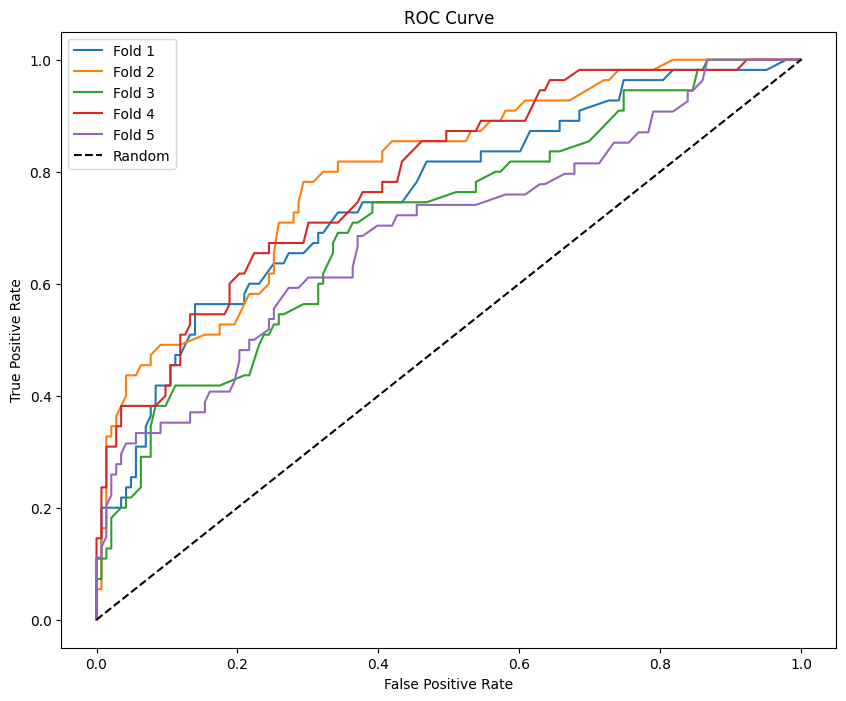

Average AUC-ROC: 0.7484278684278685


In [13]:
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np


RF_model = RandomForestClassifier()
# Define a custom scoring function that returns the confusion matrix
def custom_confusion_matrix(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = (y_pred[:, 1] >= threshold).astype(int)
    return confusion_matrix(y_true, y_pred_thresholded)

# Use StratifiedKFold for cross-validation to ensure class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validated predictions and calculate confusion matrices
# conf_matrices = []
# # X = X.values
# # y = y.values
# for train_idx, test_idx in cv.split(X, y):

#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     RF_model.fit(X_train, y_train)  # Assuming model is your RandomForestClassifier
#     y_pred = RF_model.predict_proba(X_test)
#     conf_matrix = custom_confusion_matrix(y_test, y_pred, threshold=0.3)  # Set your desired threshold here
#     conf_matrices.append(conf_matrix)

# # Compute the average confusion matrix
# avg_conf_matrix = np.sum(conf_matrices, axis=0)
# print("Average Confusion Matrix with threshold 0.2:\n", avg_conf_matrix)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize lists to store the fpr and tpr values for each threshold
all_fpr = []
all_tpr = []
all_auc = []

# X = X.values
# y = y.values
# Perform cross-validated predictions and calculate ROC curves
for train_idx, test_idx in cv.split(X, y):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict_proba(X_test)[:, 1]  # Use the probability of the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    auc = roc_auc_score(y_test, y_pred)
    all_auc.append(auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr) in enumerate(zip(all_fpr, all_tpr), 1):
    plt.plot(fpr, tpr, label=f'Fold {i}')
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Compute and print the average AUC-ROC value
avg_auc = np.mean(all_auc)
print("Average AUC-ROC:", avg_auc)

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize lists to store the fpr and tpr values for each threshold
all_fpr = []
all_tpr = []
all_auc = []

# Perform cross-validated predictions and calculate ROC curves
for train_idx, test_idx in cv.split(X, y):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict_proba(X_test)[:, 1]  # Use the probability of the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    auc = roc_auc_score(y_test, y_pred)
    all_auc.append(auc)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Compute and print the average AUC-ROC value
avg_auc = np.mean(all_auc)
print("Average AUC-ROC:", avg_auc)


NameError: name 'cv' is not defined

In [27]:
import numpy as np

def calculate_metrics(conf_matrix):
    # True Positives, False Positives, False Negatives, True Negatives
    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    
    # Calculate metrics
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    return recall, precision, accuracy

# Example confusion matrix
conf_matrix = np.array([[674, 18], [248, 28]])

# Calculate metrics
recall, precision, accuracy = calculate_metrics(conf_matrix)

print("Recall: {:.2f}".format(recall))
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(accuracy))


Recall: 0.10
Precision: 0.61
Accuracy: 0.73


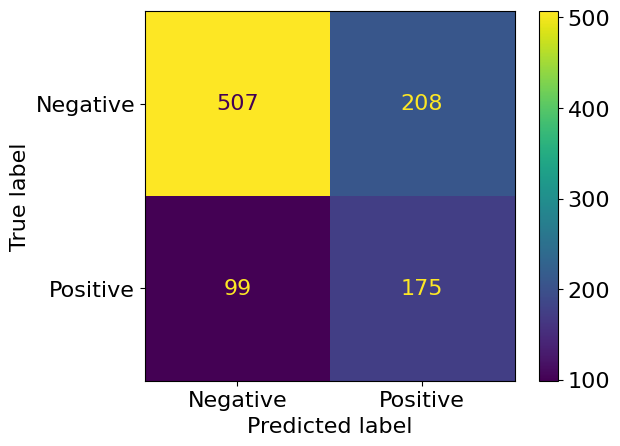

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array([[507, 208], [99, 175]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Increase font size
plt.rcParams.update({'font.size': 16})
disp.plot()
plt.show()
